# Documentation

**Data Source:** https://www.openml.org/search?type=data&sort=runs&id=1597&status=active

<br>

**Data Context:** This dataset relates to credit card transactions made by European card holders over a two day period in September 2013. It is highly imbalanced with 284,315 genuine transactions compared to just 492 fraudulent.

A PCA transformation has been applied to all features, except Time (seconds since the first recorded transaction), Amount (transaction value), and Class (genuine or fraudulent). The transformation has been applied as a privacy protecting function by the data owner, and as such, the original features have not been made publicly available.

Further information is available by following the link provided above.

<br>

**Preparation Purpose:** The purpose of this pre-processing step is to prepare the data for use in the training of a cGAN to generate synthetic data in order to improve classifer performance through dataset augmentation. Therefore, the class imbalance indicated is desirable and will be addressed as part of the wider study.

<br>

**Preparation Approach:** Preservation of minority class instances is a primary objective due to their scarcity and importance to the broader study. Furthermore, owing to the applied PCA transformation, domain knowledge cannot be effectively used to explain anomalies nor aid in creating derived features. Both of these limit the pre-processing options available.

<br>

**Preparation Overview:**
* 1.0 Configuration
* 2.0 Data Inspection
* 3.0 Data Cleaning
* 4.0 Data Splitting
* 5.0 Transformations
* 6.0 Exports

<br>

**Note:** The project cells are intended to be run sequentially in Google Colab. Coding adjustments will be needed to use the code in other environments or to employ non-standard paths through the presented cell order.

# 1.0 Configuration

### | 1.1 Imports

In [ ]:
import gc
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.io import arff
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import zipfile

### | 1.2 Visualisation Functions

In [ ]:
# graph consistency functions:

# use a consistent graph style with optional legend
def apply_style(ax, title, xlabel, ylabel, legend=False):

    # base colours
    grey_bg = '#f5f5f5'
    grey_grid = '#dadada'
    grey_borders = '#282828'

    # retrieve font sizes
    medium, large = font_size()

    # label formatting
    ax.set_title(title, fontsize=large, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=medium, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=medium, fontweight="bold")

    # x tick label formatting
    for label in ax.get_xticklabels():
        label.set_fontsize(medium)

    # y tick label formatting
    for label in ax.get_yticklabels():
        label.set_fontsize(medium)

    # optional legend formatting
    if legend == True:
        graph_legend = ax.legend(loc='upper right')
        frame = graph_legend.get_frame()
        for text in graph_legend.get_texts():
            text.set_fontsize(medium)

    # graph appearance
    ax.grid(color=grey_grid, which="both")
    ax.set_facecolor(grey_bg)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_edgecolor(grey_borders)

    # minimise overlaps
    plt.tight_layout()

# return consistent visualisation colours
def data_colours():

    # sequential visually equidistant colour scheme
    colour_one = '#ffa600'    # yellow
    # colour_two = '#dc0062'  # pink unusued
    colour_three = '#002E6E'  # blue

    return colour_one, colour_three

# return consistent font sizes
def font_size():

    medium = 9  # intended for labels
    large = 10  # intended for titles

    return medium, large


# graph plotting functions:

# plot a bar chart with custom xticks and optional log scale
def plot_bar(data, ax, title, xticks, xlabel, ylabel, log_scale=False):

    # set data colours
    colours = [data_colours()[1], data_colours()[0]]

    # create the graph on the subplot
    ax.bar(data.index, data.values, color=colours, log=log_scale)

    # set custom x axis ticks
    ax.set_xticks(data.index)
    ax.set_xticklabels(xticks)

    # apply the defined style
    apply_style(ax, title, xlabel, ylabel)

# plot a box plot
def plot_box(data, ax, title, xlabel, ylabel):

    # set data colours
    colours = [data_colours()[1], data_colours()[0]]

    # create the graph on the subplot
    sns.boxplot(x=data[xlabel], y=data[ylabel], ax=ax, saturation=1,
                palette=colours, linewidth=0.5, boxprops=dict(edgecolor='#282828'))

    # apply the defined style
    apply_style(ax, title, xlabel, ylabel)

# plot a histogram with external colour choice
def plot_hist(data, ax, title, xlabel, ylabel, colour=0):

    # set data colours
    colours = list(data_colours())

    # create the graph on the subplot
    ax.hist(data, bins=50, color=colours[colour])

    # apply the defined style
    apply_style(ax, title, xlabel, ylabel)

# plot a split bar chart
def plot_split(sets, counts, ax, title, xlabel, ylabel):

    # set data colours
    colours = [data_colours()[1], data_colours()[0]]

    # create the graph on the subplot
    sns.barplot(x=sets, y=counts, palette=colours, saturation=1)

    # apply the defined style
    apply_style(ax, title, xlabel, ylabel)

# scale plot size to number of graphs
def plot_size(rows, columns):

    # reasonable display size for a single graph
    width = 5.5
    height = 4.5

    # scaling factor
    scaling = 0.6

    # increase plot size if multiple graphs
    horizontal = ((width * scaling) * (columns - 1)) + width
    vertical = ((height * scaling) * (rows - 1)) + height

    # inverted output order to match plotting function inputs
    return horizontal, vertical

### | 1.3 Data Loading

In [ ]:
# data loading code:

# mount google drive and provide project root
drive.mount('/content/drive/', force_remount=True)
drive_prefix = '/content/drive/MyDrive/Credit Card Synthetic Data/'

# unzip stored raw data
raw_path = drive_prefix + 'data/raw/'
with zipfile.ZipFile(raw_path + 'credit card.zip', 'r') as zip_ref:
    zip_ref.extractall(raw_path)

# load unzipped raw data and convert to dataframe
data_arff = arff.loadarff(raw_path + 'credit card.arff')
data_credit = pd.DataFrame(data_arff[0])

# force display of all dataframe columns to aid inspection
pd.set_option("display.max_columns", None)

# delete unneeded data and force garbage collection
del data_arff
os.remove(raw_path + 'credit card.arff')
gc.collect();

Mounted at /content/drive/


### | 1.4 Reproducibility

In [ ]:
# random seed code:

# base and derived random seeds
random_seed = 42
random.seed(random_seed)     # for python based calculations
np.random.seed(random_seed)  # for numpy based calculations

# 2.0 Data Inspection

### | 2.1 Dataframe Information

In [ ]:
# dataframe information code:

# display dataset counts and datatypes
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Observations:**
* Data load successful as column and row  counts match the expected values.

* Class is an object data type but was expected to be an integer.

* Limited memory environments may benefit from converting float64 to float32.

**Actions:**
* Further investigate Class data type.

* Convert float64 to float32 for performance improvements.

### | 2.2 Target Variable Distribtution

In [ ]:
# class count code:

# count unique values in class column
data_credit['Class'].value_counts()

b'0'    284315
b'1'       492
Name: Class, dtype: int64

**Observations:**
* Majority and minority counts match those provided in the documentation.

* Class values are in the bytes format due to how the .arff file encodes string data.

**Actions:**
* Convert the Class values to binary integers to match algorithm expectations.

### | 2.3 Head Inspection

In [ ]:
# dataset preview code:

# display the first rows of the dataset
data_credit.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,b'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,b'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,b'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,b'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,b'0'
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,b'0'
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,b'0'
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,b'0'
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,b'0'
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,b'0'


**Observations:**
* Time and Amount have substantially different scales than the PCA transformed features.

**Actions:**
* Investigate Time and Amount statistics to confirm extent of scale disparity.

### | 2.4 Summary Statistics

In [ ]:
# statistics code:

# display dataset statistics
data_credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.205498e-16,-2.406306e-15,2.238853e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437516e-15,-3.740237e-16,9.564149e-16,1.039917e-15,6.407202e-16,1.656562e-16,-3.568593e-16,2.610582e-16,4.473066e-15,5.213180e-16,1.683537e-15,-3.659966e-16,-1.223710e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


**Observations:**
* Time appears linear and could be made cyclical but would add additional complexity.

* Sizable disparity between PCA, Time, and Amount scales and means could unduly influence models.

**Actions:**
* Keep Time as linear to simplify cGAN capability evaluation and avoid introducing confounding factors.

* Examine Time and Amount distributions and possibly standardise to aid deep learning performance.

# 3.0 Data Cleaning

### | 3.1 Identifying Missing Values

In [ ]:
# missing value code:

# count missing values in each feature
data_credit.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Observations:**

* There are no missing values in the dataset.

### | 3.2 Data Type Conversions

In [ ]:
# binary conversion code:

# convert object binary class labels to integers
data_credit["Class"] = data_credit["Class"].astype(np.int32)

# assign to variable and verify transformation
class_count = data_credit["Class"].value_counts().astype('int32')
class_count

0    284315
1       492
Name: Class, dtype: int32

**Observations:**
* Byte values now represented as binary integers to match various algorithm expectations.

* Type change has not affected the established class counts.

In [ ]:
# float conversion code:

# identify all float64 containing columns
convert_columns = data_credit.select_dtypes(include="float64").columns

# convert float64 datatypes to float32 and verify type conversion
data_credit[convert_columns] = data_credit[convert_columns].astype("float32")
data_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

**Observations:**
* Expected columns are now float32, reducing memory requirements by half.

* Time values are likely integer values stored as float.

**Actions:**
* As Time will be an input, retain as float to to suit deep learning framework optimisations.

### | 3.3 Identifying Duplicate Entries

In [ ]:
# duplicate detection code:

# identify all duplicates and filter by class
duplicates_all = data_credit[data_credit.duplicated()]
duplicates_0 = duplicates_all[duplicates_all["Class"] == 0].shape[0]
duplicates_1 = duplicates_all[duplicates_all["Class"] == 1].shape[0]

# calculate duplicate percent per class
percentage_0 = (duplicates_0 / class_count[0]) * 100
percentage_1 = (duplicates_1 / class_count[1]) * 100

# print duplicate information
print("Exact Duplicates:")
print(f"0\t {duplicates_0} \t ({percentage_0:.2f}%)")
print(f"1\t {duplicates_1} \t ({percentage_1:.2f}%)")

Exact Duplicates:
0	 1062 	 (0.37%)
1	 19 	 (3.86%)


**Observations:**
* The 0.37% majority class duplicates represent a minor overfitting threat.

* These duplicates are possibly system errors, recording mistakes, or undetected fraud.

* The 3.86% of minority duplicates represent a significant amount of a small class.

* The PCA transformation prevents domain knowledge being used to interpret duplicates.

**Actions:**
* Remove only exact duplicate majority class instances.

* Retain minority duplicates to preserve scarce training information.

In [ ]:
# duplicate removal code:

# instance count before removal
raw_total = data_credit.shape[0]

# separate majority and minority classes
majority_class = data_credit[data_credit["Class"] == 0]
minority_class = data_credit[data_credit["Class"] == 1]

# check if majority classes have already been removed
if majority_class.duplicated().sum() > 0:

    # drop majority duplicates
    majority_class = majority_class.drop_duplicates()

    # concatenate separated dataframes
    data_credit = pd.concat([majority_class, minority_class], axis=0)

    # verify new instance count
    print("Original Instances:", raw_total)
    print("Actual Instances:  ", data_credit.shape[0])
    print("Removed Instances: ", raw_total - data_credit.shape[0])

# if duplicates have already been removed
else:
    print("Majority instances removed previously")

Original Instances: 284807
Actual Instances:   283745
Removed Instances:  1062


**Observations:**
* The correct number of instances have been removed from the majority class.

### | 3.4 Outlier Treatment

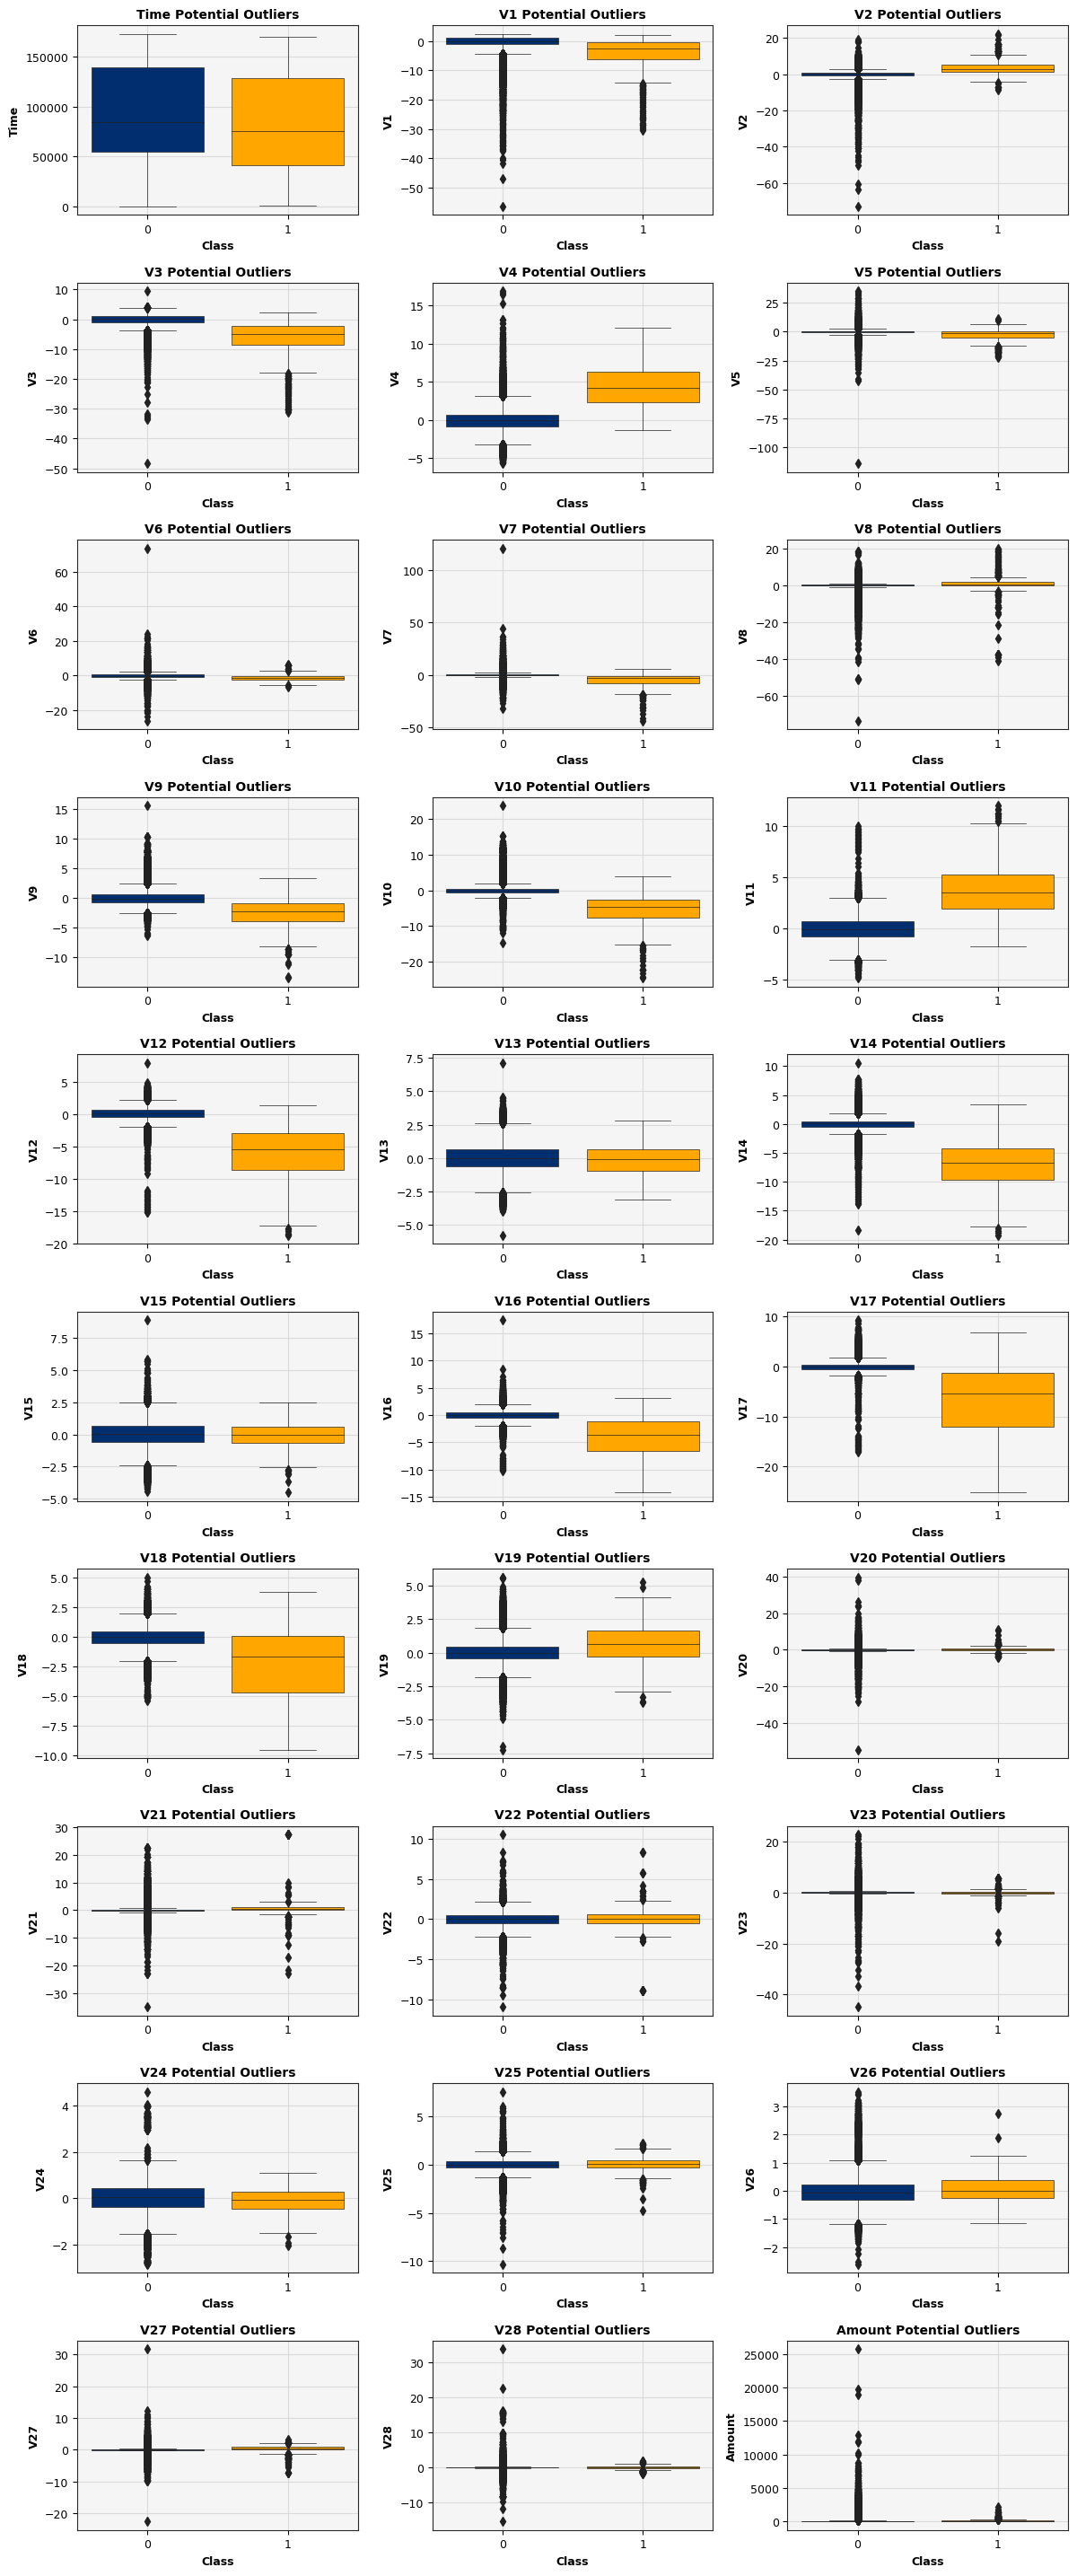

In [ ]:
# outlier visualisation code:

# list of columns possibly containing outliers
outlier_columns = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
                   'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16',
                   'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
                   'V25', 'V26', 'V27', 'V28', 'Amount']

# graph plot area
horizontal_plots = 10
vertical_plots = 3
plt.figure(figsize=(plot_size(horizontal_plots, vertical_plots)))

# outlier box and whisker graph loop
for i, column in enumerate(outlier_columns, 1):
    ax = plt.subplot(horizontal_plots, vertical_plots, i)
    plot_box(data_credit, ax, column  + ' Potential Outliers', "Class", column)

**Observations:**
* Likely outliers seen in features such as V5-7 and V26.

* The PCA transformation prevents domain knowledge being used to interpret outliers.

* The assumption that the PCA transformation results in centered data holds true.

* Logically, there will be legitimate extreme values in columns like Amount.

**Actions:**
* Retain all outliers rather than blind removal leading to lost information.

# 4.0 Data Splitting

### | 4.1 Visualise Imbalance

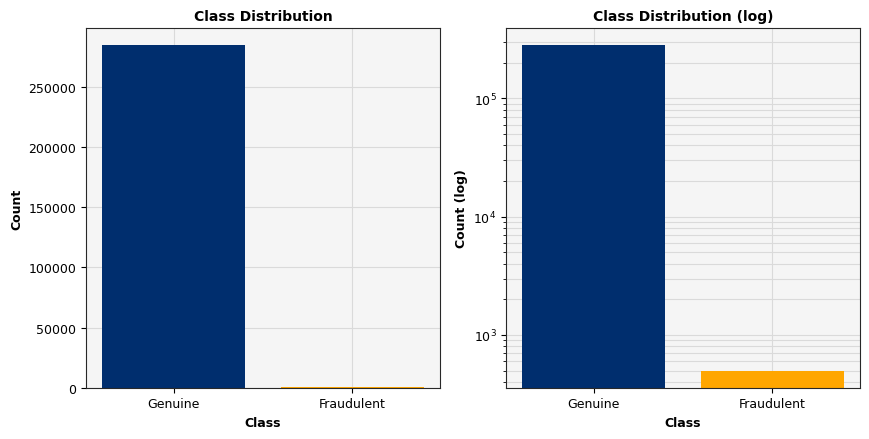

In [ ]:
# imbalance bar chart code:

# graph plot area
fig, ax = plt.subplots(1, 2, figsize=(plot_size(1, 2)))

# class distribution bar graph with no log scale
plot_bar(class_count,
         ax[0],
         "Class Distribution",
         ["Genuine", "Fraudulent"],
         "Class",
         "Count")

# class distribution bar graph with log scale
plot_bar(class_count,
         ax[1],
         "Class Distribution (log)",
         ["Genuine", "Fraudulent"],
         "Class",
         "Count (log)",
         log_scale=True,)

**Observations:**

* Severe class imbalance may result in insufficient minority instances across a train-test split.

* Larger training splits would provide more valuable training data and prevent underfitting.

* Larger test splits would provide more robust performance evaluation.

**Actions:**

* Apply stratified sampling to the dataset to ensure a representative split.

* Use a 75 training 25 test split as a midpoint of common data splits.

### | 4.2 Stratified Split

In [ ]:
# train test split code:

# separate target variable from dataset
X = data_credit.drop("Class", axis=1)
y = data_credit["Class"]

# reproducibile stratified 75/25 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25,  random_state=random_seed, stratify=y)

# verify training distribution
print("y_train Class Distribution:")
print(y_train.value_counts())

# verify test distribution
print("\ny_test Class Distribution:")
print(y_test.value_counts())

y_train Class Distribution:
0    212439
1       369
Name: Class, dtype: int64

y_test Class Distribution:
0    70814
1      123
Name: Class, dtype: int64


**Observations:**
* The stratified split has preserved class representation in both the training and test data.

* As expected, 75% of each class is in the training set and 25% in the test set.

# 5.0 Transformations

### | 5.1 Visualise Distributions

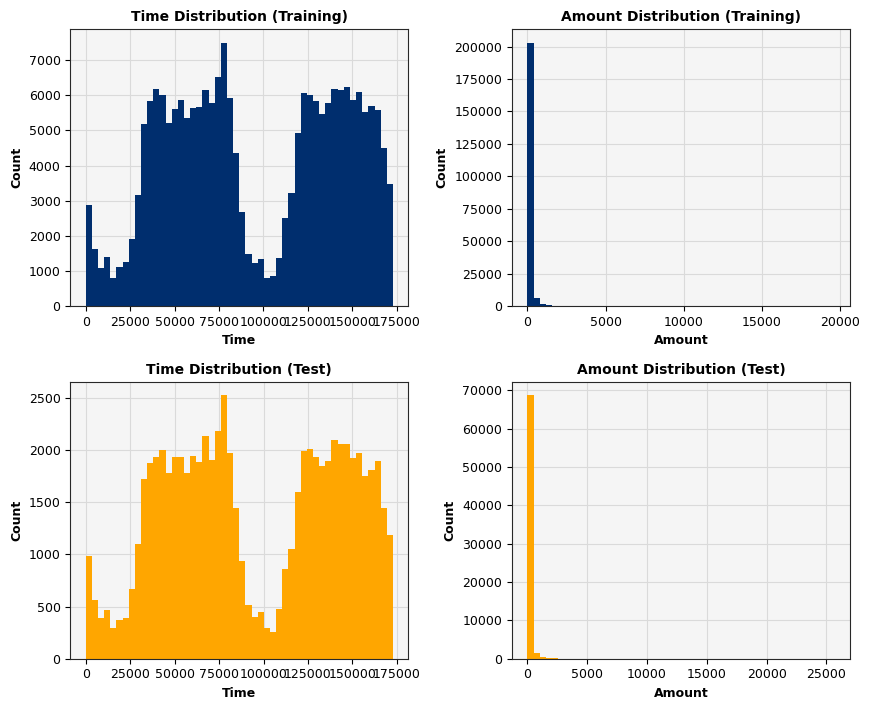

In [ ]:
# graph figure code:

# graph plot area
horizontal_plots = 2
vertical_plots = 2
fig, ax = plt.subplots(vertical_plots,
                       horizontal_plots,
                       figsize=(plot_size(vertical_plots, horizontal_plots)))


# training and test visualisation code:

# check if transformation has already been applied
if ("Time" in X_train.columns and "Amount" in X_train.columns) and (
    "Time" in X_test.columns and "Amount" in X_test.columns):

    # time histogram for training set with second colour
    plot_hist(X_train["Time"],
              ax[0, 0],
              "Time Distribution (Training)",
              "Time",
              "Count",
              1)

    # amount histogram for training set with second colour
    plot_hist(X_train["Amount"],
              ax[0, 1],
              "Amount Distribution (Training)",
              "Amount",
              "Count",
              1)

    # time histogram for test set with default colour
    plot_hist(X_test["Time"],
              ax[1, 0],
              "Time Distribution (Test)",
              "Time",
              "Count")

    # amount histogram for test set with default colour
    plot_hist(X_test["Amount"],
              ax[1, 1],
              "Amount Distribution (Test)",
              "Amount",
              "Count")

# if transformation has already been applied
else:
    print("These columns have been removed as part of the transformation code")

    # remove blank figure from output
    plt.close(fig)

**Observations:**
* As both Time and Amount columns contain outliers, normalisation could result in a very small data range.

* Neither Time nor Amount have a standardised mean, unlike the PCA transformed features.

* Amount is right skewed with high extremes, both requiring intervention.

**Actions:**
* Apply a logarithmic transformation with a small constant to the Amount values.

* Standardise training data and apply those scales to test data to avoid data leakage.

In [ ]:
# log transform code:

# amount log transform with log(0) precaution
X_train["Amount_log"] = np.log(X_train["Amount"] + 0.01)
X_test["Amount_log"] = np.log(X_test["Amount"] + 0.01)


# data scaler code:

# create scalers
scaler_time = StandardScaler()
scaler_amount = StandardScaler()

# fit and transform training data
X_train["Time_std"] = scaler_time.fit_transform(X_train[["Time"]])
X_train["Amount_std"] = scaler_amount.fit_transform(X_train[["Amount_log"]])

# transform test data with training scaler to avoid data leakage
X_test["Time_std"] = scaler_time.transform(X_test[["Time"]])
X_test["Amount_std"] = scaler_amount.transform(X_test[["Amount_log"]])


# data removal code:

# remove original and helper columns
X_train = X_train.drop(columns=["Time", "Amount", "Amount_log"])
X_test = X_test.drop(columns=["Time", "Amount", "Amount_log"])

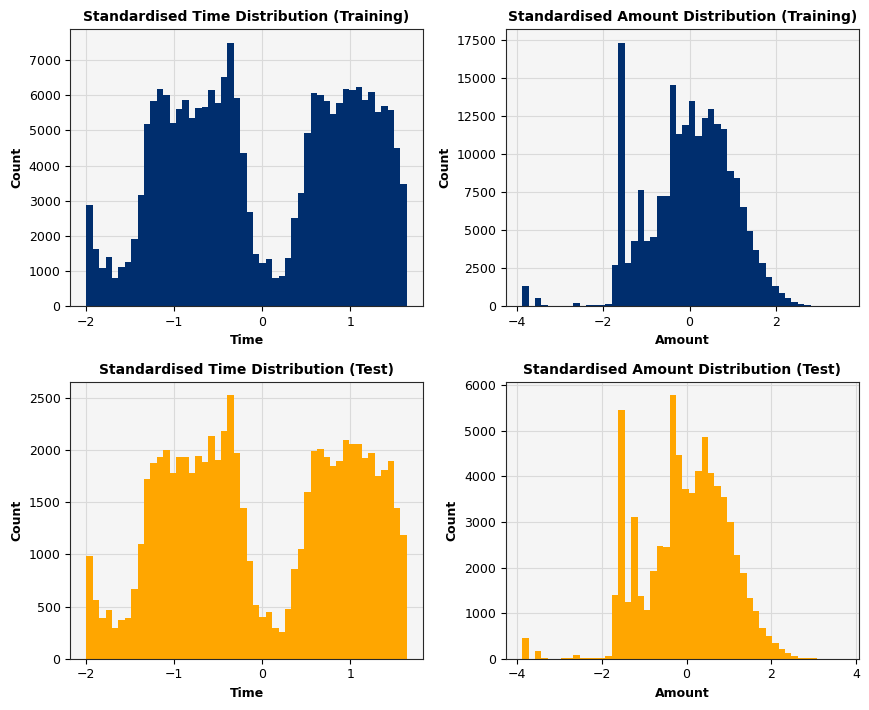

In [ ]:
# graph figure code:

# graph plot area
horizontal_plots = 2
vertical_plots = 2
fig, ax = plt.subplots(vertical_plots,
                       horizontal_plots,
                       figsize=(plot_size(vertical_plots, horizontal_plots)))


# training and test visualisation code:

# check if transformation has not been applied
if ("Time_std" in X_train.columns and "Amount_std" in X_train.columns) and (
    "Time_std" in X_test.columns and "Amount_std" in X_test.columns):

    # standardised time histogram for training set with second colour
    plot_hist(X_train["Time_std"],
              ax[0, 0],
              "Standardised Time Distribution (Training)",
              "Time",
              "Count",
              1)

    # standardised amount histogram for training set with second colour
    plot_hist(X_train["Amount_std"],
              ax[0, 1],
              "Standardised Amount Distribution (Training)",
              "Amount",
              "Count",
              1)

    # standardised time histogram for test set with default colour
    plot_hist(X_test["Time_std"],
              ax[1, 0],
              "Standardised Time Distribution (Test)",
              "Time",
              "Count")

    # standardised amount histogram for test set with default colour
    plot_hist(X_test["Amount_std"],
              ax[1, 1],
              "Standardised Amount Distribution (Test)",
              "Amount",
              "Count")

# standardised if transformation has already been applied
else:
    print("These columns have not yet been added by the transformation code")

    # remove blank figure from output
    plt.close(fig)

**Observations:**
* Both Time and Amount have been standardised and data better matches PCA transformed statistics.

* The Amount skewness has been successfully corrected.

* Data is now more suitable for a broader range of machine learning algorithms.

**Actions:**
* Export train and test datasets for use in later phases of the study.

# 6.0 Exports

### | 6.1 Visualise Data

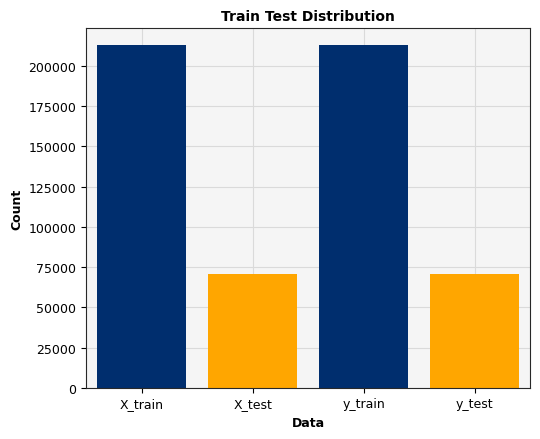

In [ ]:
# train test visualisation code:

# graph plot area
fig, ax = plt.subplots(1, 1, figsize=(plot_size(1, 1)))

# names and counts for visualisation
set_names = ["X_train", "X_test", "y_train", "y_test"]
set_counts = [X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]]

# visualise train test instance distribution
plot_split(
    set_names, set_counts, ax, "Train Test Distribution", "Data", "Count")

**Observations:**

* 75% of processed data is in training sets ready for use in cGAN and classifier benchmarking.

* 25% of processed data is in test sets without data leaks and ready for use in model evaluation.

### | 6.2 Export Data

In [ ]:
# data exporting code:

# export training data to pickle format
X_train.to_pickle(drive_prefix + "data/processed/X_train.pkl")
y_train.to_pickle(drive_prefix + "data/processed/y_train.pkl")

# export test data to pickle format
X_test.to_pickle(drive_prefix + "data/processed/X_test.pkl")
y_test.to_pickle(drive_prefix + "data/processed/y_test.pkl")